# Pitch Scape Tutorial

## Quick Start

Throughout this tutorial, I will use two pieces as examples: Johann Sebastian Bach's _Prelude in C major (BWV 846)_ and Ludwig van Beethoven's "Moonlight Sonata" _Sonata No. 14 in C# minor (Op. 27, No. 2)_. Here is the first bar from both:

<img src="./doc/Prelude_No_1_BWV_846_in_C_Major.png" alt="Johann Sebastian Bach, Prelude in C major, BWV 846" width="40%"/>
<img src="./doc/Sonata_No._14_Op._27_No._2_-_Ludwig_van_Beethoven.png" alt="Ludwig van Beethoven, Sonata No. 14 in C# minor, Op. 27, No. 2" width="40%"/>

The quickest way to some nice plots is to load a piece and do a key-scape plot.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.random.seed(0)  # make reproducible

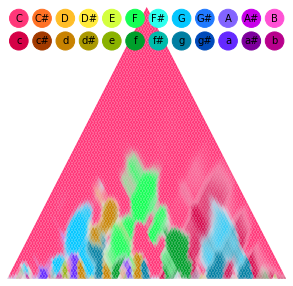

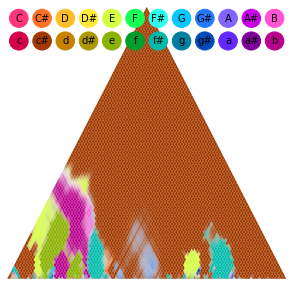

In [2]:
import pitchscapes.reader as rd
import pitchscapes.plotting as pt
scape_JSB = rd.get_pitch_scape('./doc/Prelude_No_1_BWV_846_in_C_Major.mid')
scape_LvB = rd.get_pitch_scape('./doc/Sonata_No._14_Op._27_No._2_-_Ludwig_van_Beethoven.mid')
pt.key_scape_plot(scape=scape_JSB, n_samples=100, size=5)
pt.key_scape_plot(scape=scape_LvB, n_samples=100, size=5);

And here are the separate pitch-scape plots, you can see quite clearly that one is in C-major and the other in c#-minor.

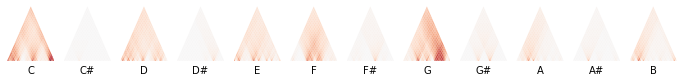

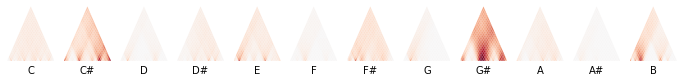

In [3]:
pt.pitch_scape_plots(scape=scape_JSB, n_samples=30);
pt.pitch_scape_plots(scape=scape_LvB, n_samples=30);

Now, for a quick start, let's train a mixture model with two cluster on these pieces. This can take a minute – in the background there are 2904 variables being optimised.

epoch 210 | batch 1/1 | time elapsed 0:00:34.340588 | batch loss: -32.80711 | epoch loss: -32.80711 | delta[100]: -0.86283


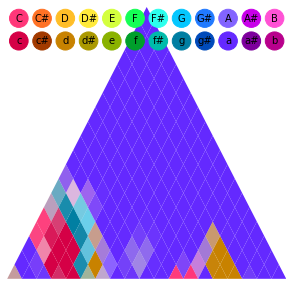

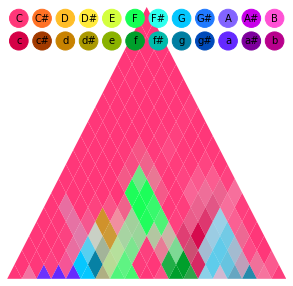

In [4]:
from pitchscapes import PitchScapeMixtureModel
model = PitchScapeMixtureModel(n_clusters=2)
model.set_data(scapes=[scape_JSB, scape_LvB], n_samples=20)
model.optimize()
for c in model.clusters():
    pt.key_scape_plot(scape=c, n_samples=20, size=5);

Do you recognise which cluster represents which piece?

**Hint:** _Clusters are transposition invariant but we have to choose a transposition to visualise them. The default initialisation gives them a bias towards the diatonic without accidentals (C-major / a-minor). So pieces in minor mode will appear to be transposed to a-minor..._

## Step-by-Step

Now let's understand a bit more of what is going on behind the scenes. First some more imports and setting for later.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pitchscapes import PitchScape
np.set_printoptions(precision=3, linewidth=1000)  # for more compact printing

### Reading Files

The `get_pitch_scape` function is a shortcut for doing two things:
1. using `pitch_class_counts` to read pitch-class counts from a file and
2. constructing a `PitchScape` object from these data.

In [6]:
counts, times = rd.pitch_class_counts('./doc/Prelude_No_1_BWV_846_in_C_Major.mid')
print("data of the fist quarter note of the first bar:")
print(counts[:6])
print(times[:7])
print(len(counts), len(times))

data of the fist quarter note of the first bar:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[0.    0.25  0.5   0.748 0.75  0.998 1.   ]
1020 1021


The `pitch_class_counts` function returns a 2D-array of pitch-class counts for all time intervals where no note-on or note-off event happens (i.e. where the counts are constant) and a 1D-array of times that correspond to the interval boundaries. So there is one more element in times than in counts. The extremely short time intervals come from the MIDI exporter adding short silence between two consecutive notes, this can safely be ignored. From these data, we can construct a `PitchScape` object and plot it as above.

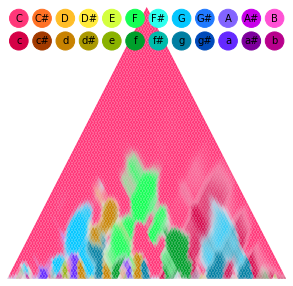

In [7]:
scape = PitchScape(values=counts, times=times)
pt.key_scape_plot(scape=scape, n_samples=100, size=5);

Pitch scapes give you access to the pitch-class counts of any time interval between `min_time` and `max_time` (time is measured in beats or quarter notes).

In [8]:
start, end = sorted(np.random.uniform(scape.min_time, scape.max_time, 2))
print(f"pitch counts in [{start}, {end}]:")
print(scape[start, end])

pitch counts in [53.36684701656922, 60.56848302771739]:
[0.661 0.    0.209 0.    2.15  1.483 0.    1.583 0.837 0.023 0.    0.248]


As per default, these values correspond to the sum of all pitch-class counts within the specified time interval (the integral over the pitch-class density). If you want to have normalised values, just say so:

In [9]:
normalised_scape = PitchScape(values=counts, times=times, normalise=True)
print(f"normalised pitch counts in [{start}, {end}]:")
print(normalised_scape[start, end])

normalised pitch counts in [53.36684701656922, 60.56848302771739]:
[0.092 0.    0.029 0.    0.299 0.206 0.    0.22  0.116 0.003 0.    0.034]


In a key-scape plot you wouldn't see the difference because normalisation does not affect the key estimates (values are actually internally normalised before computing the estimates). But in the separate pitch-scape plots you can see the difference if you disable the internal normalisation of the plotting function:

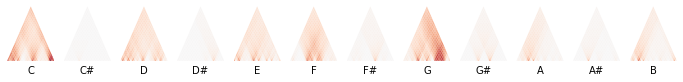

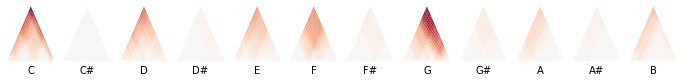

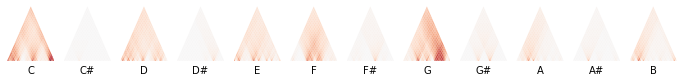

In [10]:
# normalisation done by pitch scape, not by the plotting function
pt.pitch_scape_plots(scape=normalised_scape, n_samples=30, normalise=False);
# no normalisation: you see counts summing up towards the top
pt.pitch_scape_plots(scape=scape, n_samples=30, normalise=False);
# normalisation done by the plotting function, not by the pitch scape (default)
pt.pitch_scape_plots(scape=scape, n_samples=30);

**Note:** _Unnormalised_ pitch-scape plots of a _normalised_ pitch scape (first row) look exactly like _normalised_ pitch-scape plots (default) of an _unnormalised_ (default) pitch scape (third row).

### Plotting

You can controll several aspects of the plots, such as

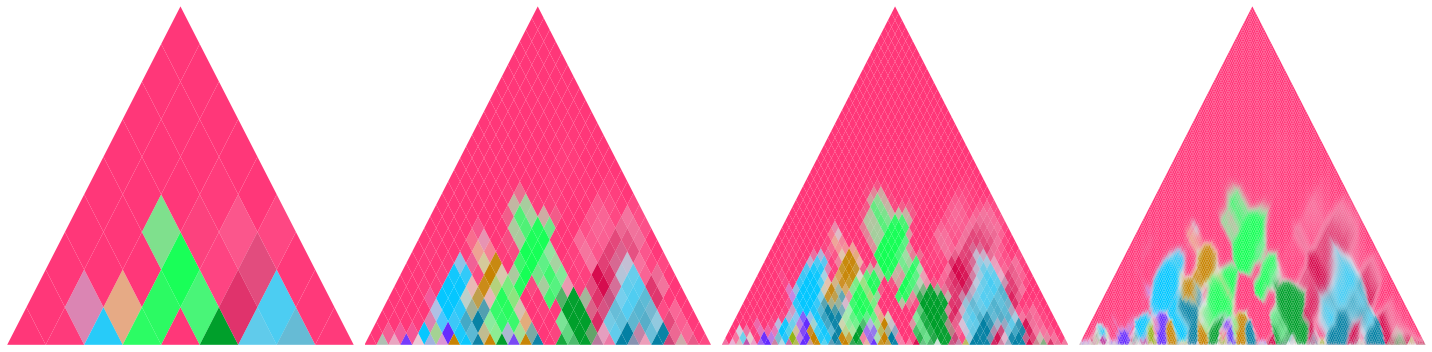

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
pt.key_scape_plot(scape=scape, n_samples=10, ax=axes[0], legend=False)
pt.key_scape_plot(scape=scape, n_samples=30, ax=axes[1], legend=False)
pt.key_scape_plot(scape=scape, n_samples=50, ax=axes[2], legend=False)
pt.key_scape_plot(scape=scape, n_samples=150, ax=axes[3], legend=False)
fig.tight_layout()

 * changing the resolution

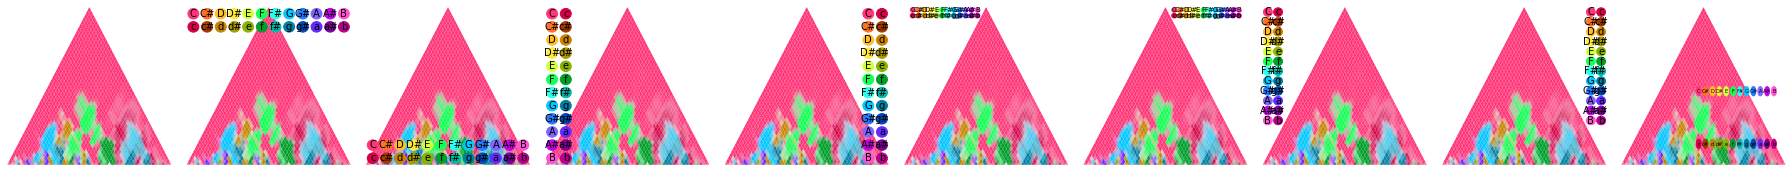

In [12]:
fig, axes = plt.subplots(1, 10, figsize=(25, 2.5))
pt.key_scape_plot(scape=scape, n_samples=50, ax=axes[0], legend=False)
pt.key_scape_plot(scape=scape, n_samples=50, ax=axes[1], location='top')
pt.key_scape_plot(scape=scape, n_samples=50, ax=axes[2], location='bottom')
pt.key_scape_plot(scape=scape, n_samples=50, ax=axes[3], location='left')
pt.key_scape_plot(scape=scape, n_samples=50, ax=axes[4], location='right')
pt.key_scape_plot(scape=scape, n_samples=50, ax=axes[5], location='top left')
pt.key_scape_plot(scape=scape, n_samples=50, ax=axes[6], location='top right')
pt.key_scape_plot(scape=scape, n_samples=50, ax=axes[7], location='left small')
pt.key_scape_plot(scape=scape, n_samples=50, ax=axes[8], location='right small')
pt.key_scape_plot(scape=scape, n_samples=50, ax=axes[9], x_scale=0.5, y_scale=4, x_offset=0.7, y_offset=0.3, horizontal=True, fontsize=5, label_size=0.5, aspect=0.5)
fig.tight_layout()

 * changing properties of the legend

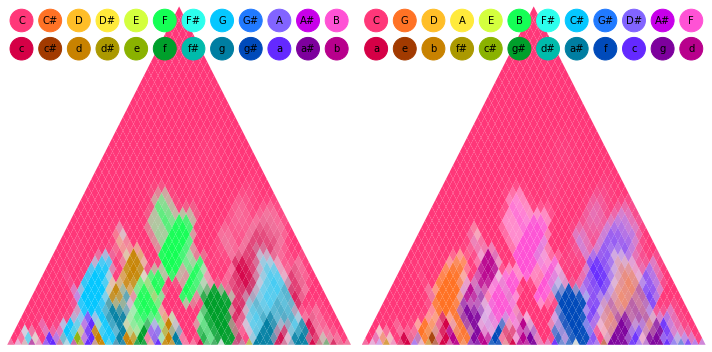

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
pt.key_scape_plot(scape=scape, n_samples=50, ax=axes[0], circle_of_fifths=False)
pt.key_scape_plot(scape=scape, n_samples=50, ax=axes[1], circle_of_fifths=True)
fig.tight_layout()

 * choosing chromatic or fifths-based colouring (note that the legend also changes) – fifths-based colouring is more "harmonic" and less contrasting, both have their pros and cons

**Note:** You can set this property globally to `True` or `False` with `pt.set_circle_of_fifths()`.

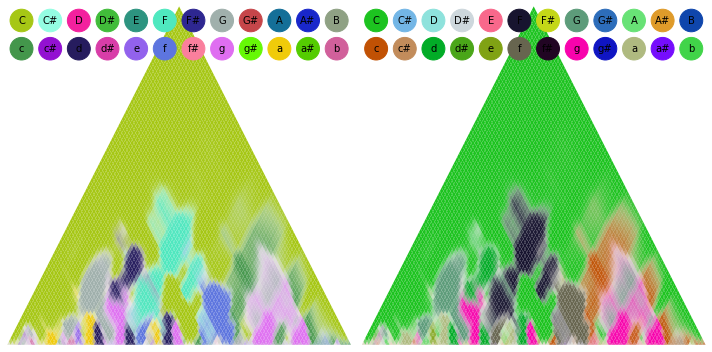

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
pt.key_scape_plot(scape=scape, n_samples=100, ax=axes[0], palette=np.random.uniform(0, 1, (12, 2, 3)))
pt.key_scape_plot(scape=scape, n_samples=100, ax=axes[1], palette=np.random.uniform(0, 1, (12, 2, 3)))
fig.tight_layout()

 * or choosing an entirely different colour palette.

### Clustering

Now let's do clustering with more than one piece per cluster. For this we will cut random parts off the beginning and end of Bach's and Beethoven's piece and randomly transpose them to artificially generate two clusters of similar but not identical pieces.

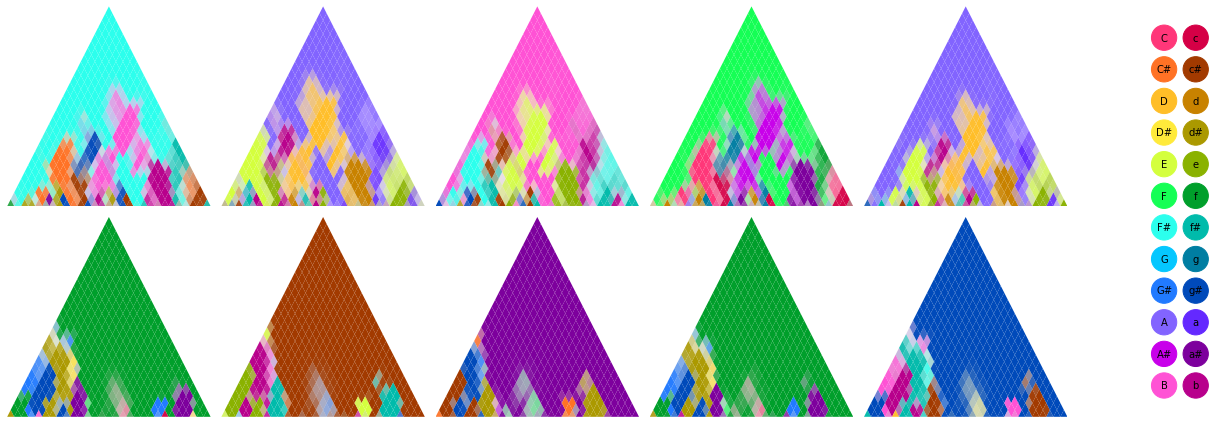

In [15]:
# read the original pieces
counts_JSB, times_JSB = rd.pitch_class_counts('./doc/Prelude_No_1_BWV_846_in_C_Major.mid')
counts_LvB, times_LvB = rd.pitch_class_counts('./doc/Sonata_No._14_Op._27_No._2_-_Ludwig_van_Beethoven.mid')
# generate artificial pieces by cutting start/end and transposing
n_pieces = 5
pieces = [[PitchScape(np.roll(c[s:e], shift=shift, axis=1), t[s:e + 1]) 
           for s, e, shift in zip(np.random.randint(0, 200, n_pieces),             # random start
                                  np.random.randint(len(c)-200, len(c), n_pieces), # random end
                                  np.random.randint(0, 12, n_pieces))]             # random transposition
          for c, t in [(counts_JSB, times_JSB), (counts_LvB, times_LvB)]]
# plot the pieces
fig, axes = plt.subplots(2, n_pieces + 1, figsize=(3 * (n_pieces + 1), 3 * 2))
for ps, axs in zip(pieces, axes):
    for p, ax in zip(ps, axs):
        pt.key_scape_plot(scape=p, n_samples=30, ax=ax, legend=False)
pt.key_legend(horizontal=False, ax=plt.subplot2grid((2, n_pieces + 1), (0, n_pieces), rowspan=2, fig=fig))
fig.tight_layout()

Now we set up a model with two clusters, provide the pieces as data and train it.

epoch 234 | batch 1/1 | time elapsed 0:00:41.514848 | batch loss: -30.15359 | epoch loss: -30.15359 | delta[100]: 0.36596


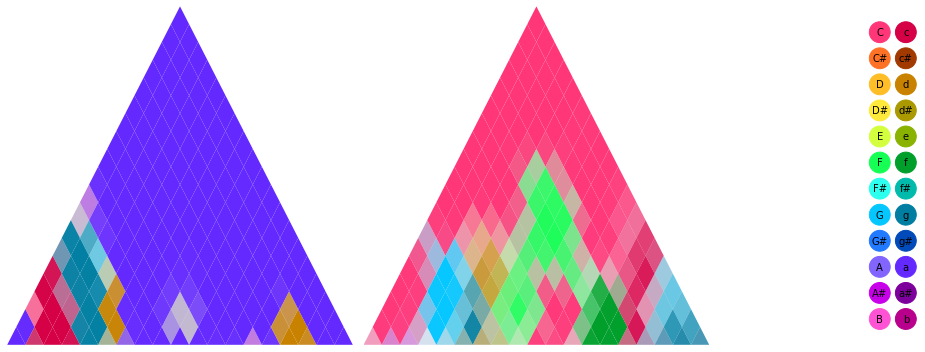

In [16]:
# set up model and data
data = pieces[0] + pieces[1]
model = PitchScapeMixtureModel(n_clusters=2)
model.set_data(scapes=data, n_samples=20)
# train
model.optimize()
# plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, c in zip(axes, model.clusters()):
    pt.key_scape_plot(scape=c, n_samples=20, size=5, ax=ax, legend=False)
pt.key_legend(horizontal=False, ax=axes[2])
fig.tight_layout()

You can look at the learning progress – the downwards kink, this is where the two clusters (which were initialised almost identically) separated to capture the two different groups of pieces. There might also be some upward wiggles or spikes towards the end. This happens if the gradient step is too large and can be counteracted with a smaller learning rate.

**Note:** The best parameter set (with smallest loss) is remembered and restored after the optimisation.

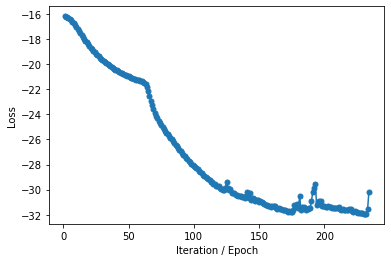

In [17]:
pt.plot_loss(model.loss);

We can also look at the assignments, first separated by cluster:

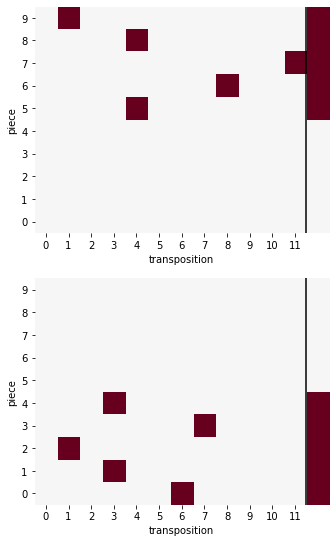

In [18]:
pt.plot_cluster_assignments(model.assignments());

The marginal on the right indicates the probability of a piece being assign to the specific cluster, the "interior" shows how this probability is distributed over different transpositions. Very clearly, the two groups of pieces are correctly assigned to the two clusters. Also the transposition was correctly inferred – you can check with the key-scape plots above. We can also look at the assignment separated by pieces:

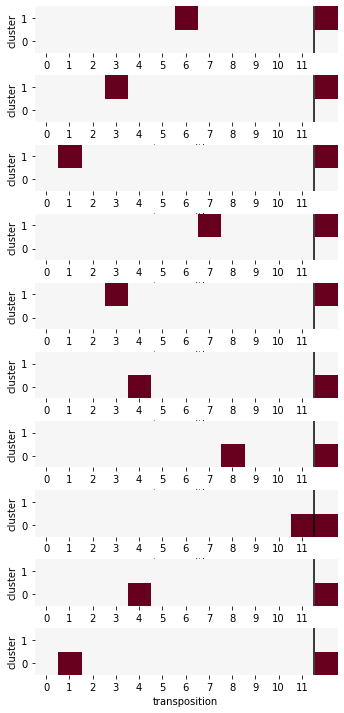

In [19]:
pt.plot_piece_assignments(model.assignments());

### Progressive and Hierarchical Clustering

OK, this was good to get an intuition of how training the model works. But in practice, we will usually have larger data sets and more than two clusters (maybe we don't even know in advance how many clusters we want to have) and these models take a while to train. So we may want to progressively refine the model and split clusters hierarchically, starting with a very simple model.

epoch 152 | batch 1/1 | time elapsed 0:00:01.033879 | batch loss: -21.08501 | epoch loss: -21.08501 | delta[100]: -0.95777


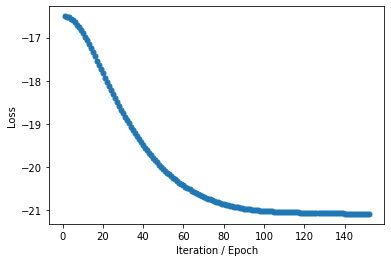

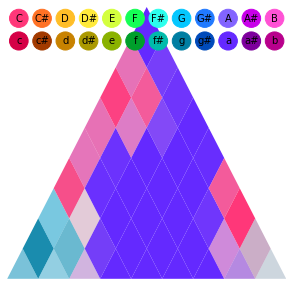

In [20]:
model = PitchScapeMixtureModel(n_clusters=1, # one cluster
                               n_center=1,   # low horizontal resolution
                               n_width=1)    # low vertical resolution
model.set_data(scapes=data, n_samples=10)  # low number of samples, which is enough for the low resolution
model.optimize()
pt.plot_loss(model.loss)
pt.key_scape_plot(model.cluster(0), 10, size=5);

Now – and this is the important new technique – we can derive new and more complex models from the pretrained one. Let's first simply increase the resolution.

epoch 101 | batch 1/1 | time elapsed 0:00:06.733284 | batch loss: -21.76254 | epoch loss: -21.76254 | delta[100]: -0.89052


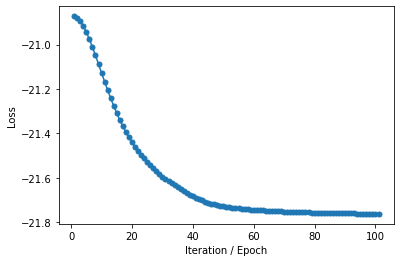

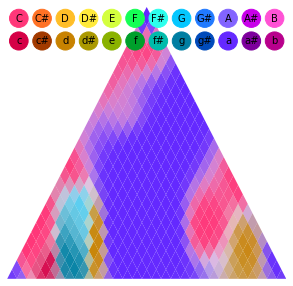

In [21]:
model = model.new(n_center=3, n_width=3)  # only increase the resolution – everything else is copied from the old model, including the already learned parameters
model.set_data(scapes=data, n_samples=30)  # more samples for higher resolution
model.optimize()
pt.plot_loss(model.loss)
pt.key_scape_plot(model.cluster(0), 30, size=5);

Now it's time to have more clusters. This can be done by cloning the existing ones.

epoch 223 | batch 1/1 | time elapsed 0:00:42.977221 | batch loss: -31.53426 | epoch loss: -31.53426 | delta[100]: -0.96586


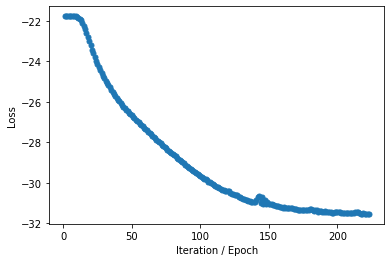

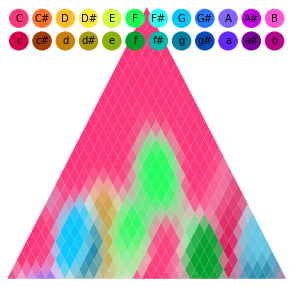

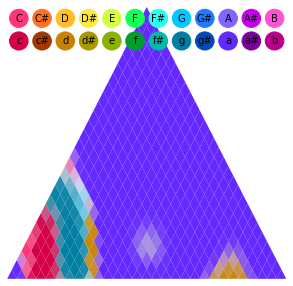

In [22]:
model = model.new(clone=[2])  # the one and only cluster is cloned twice
model.set_data(scapes=data, n_samples=30)
model.optimize()
pt.plot_loss(model.loss)
for c in model.clusters():
    pt.key_scape_plot(c, 30, size=5);

Here we are, this looks like the clusters matching the two original pieces. We can confirm this by looking at the cluster assignments.

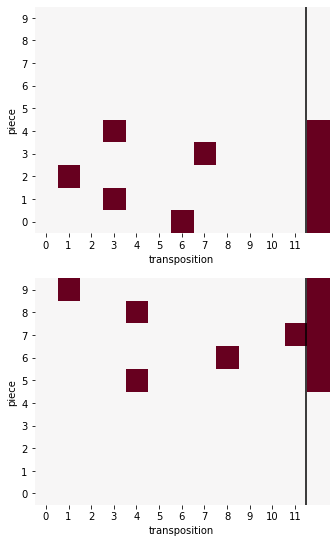

In [23]:
pt.plot_cluster_assignments(model.assignments());

With a real data set we might now go on splitting and refining the clusters. With our small artificial data set, just for fun, we will end by splitting each of the two clusters into five and see whether they can separate the single pieces – which might not be possible, depending on how similar they turned out to be.

epoch 121 | batch 1/1 | time elapsed 0:01:51.685311 | batch loss: -29.40435 | epoch loss: -29.40435 | delta[100]: 2.96609


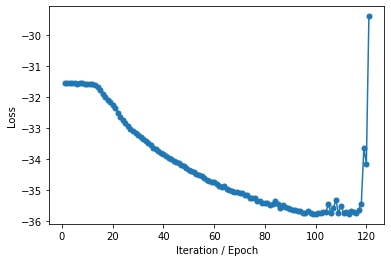

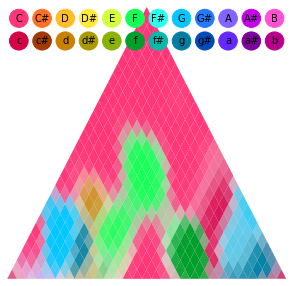

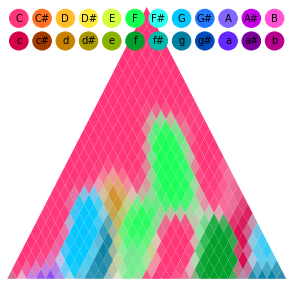

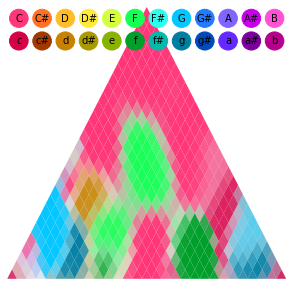

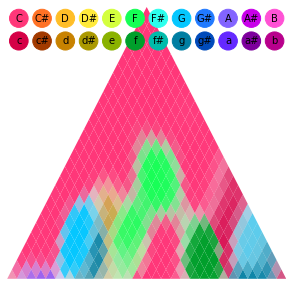

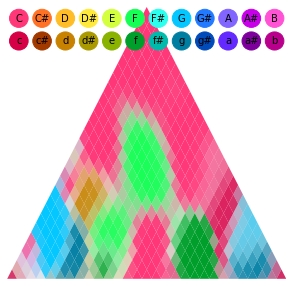

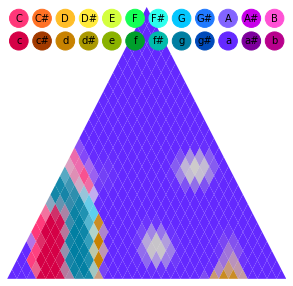

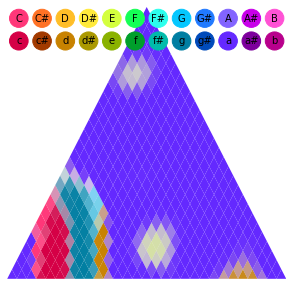

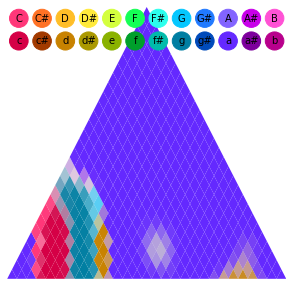

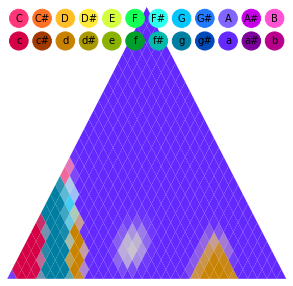

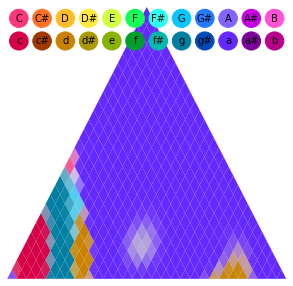

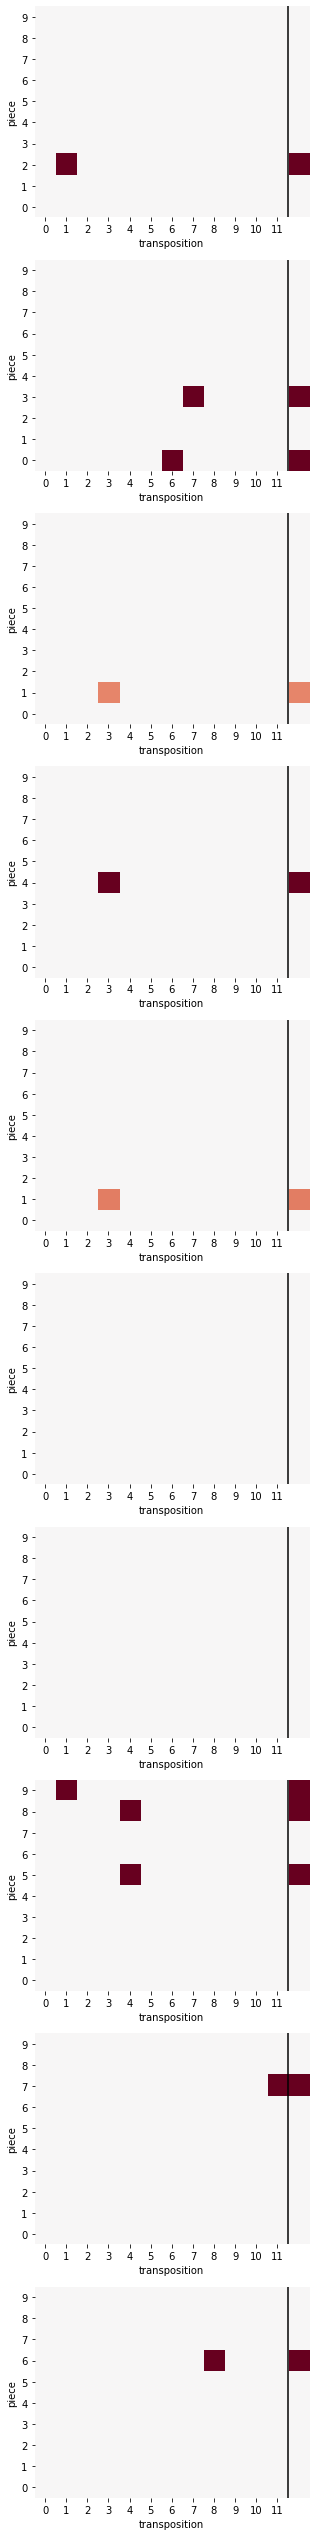

In [24]:
model = model.new(clone=[5, 5])  # both clusters split into five
model.set_data(scapes=data, n_samples=30)
model.optimize()
pt.plot_loss(model.loss)
for c in model.clusters():
    pt.key_scape_plot(c, 30, size=5);
pt.plot_cluster_assignments(model.assignments());

### Some technical details...

There are some technical details about the training procedure worth knowing.

#### Emtpy Clusters

The optimisation space is very high-dimensional, which means that any random initialisation is likely to be totally off any of the data points. This can cause a problem: If multiple clusters are very similar but all very much off the data, they will enter a "race" towards the data, which probably only one of them will win. The cluster that is nearest to the data will be most attracted and therefore in the next step be even more ahead of the others. The result is "emtpy" clusters that do not have any data points assigned to them. This can be avoided by starting with only a single cluster and initialising new clusters by splitting/cloning existing ones, as demonstrated above. The safest is to only do binary splits; when splitting into more components (as in the last example above) this may also lead to clusters being "left behind" and ending up empty.

#### Splitting Clusters and Learning Rate

A challenge with progressive and hierarchical clustering is that when splitting a cluster, the initial parameters are very close to each other _and_ very close to an optimum (after all they correspond to the optimum before splitting). This implies two things:

1. We need to separate them a bit so they can take different paths in the subsequent optimisation. This is done by adding some noise to the parameters to shift them a bit into some random direction. Now, as they were close to an optimum, a random direction is highly unlikely to improve the model or even leave the loss unchanged. So you will see the model to drop a bit in quality (increase in loss) after splitting. This is not a problem and will quickly vanish at the beginning of the subsequent optimisation. The point where the split clusters really start separating shows up as a downward kink in the loss: Before that point they jointly sit on a saddle point of the objective function; after that point one runs down one side of the saddle and the other one the other side.
2. As the clusters already are close to an optimum, we want to make sure not to mess up their parameters by taking huge gradient steps in the wrong direction. Especially, because the noise we have to add for separating them will also introduce noise in the gradients. We therefore employ a custom adaptation of the Adam optimiser (it's called _WarmAdam_ because it's for warm starts) that has an initial learning rate and then slowly transitions to a final learning rate. The initial learning rate is set to zero by default, which allows Adam to get an idea of how the gradients look like before starting to run after it. It will then slowly transition to the final learning rate to actually make progress. In the loss plots you see the small initial learning rate at the beginning where there is little progress before the model dives into the optima as the learning rate increases and the loss starts decreasing more rapidly. The final flattening is not induced by a change in learning rate but is the usual and desired convergence to an optimum.